<a href="https://colab.research.google.com/github/pedrofuentes79/RNNs/blob/master/Sentiment-Analysis/sentAnalysis_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN Implementation

The notebook's goal is to showcase the effectiveness of a CNN architecture for sentiment analysis. This notebook aims to solve the same problem as the [main notebook](https://colab.research.google.com/drive/1ZgBBP-_7nP-BwdoZbC9YdkLo9_opky-p?usp=sharing), but with different model architecture.
Though CNNs are normally used for image processing, they are very capable of handling sequential information.

This implementation uses the same Word2Vec model for the word embeddings as the other implementations. The model was pretrained on the amazon dataset.

Note that this model skips some of the data preprocessing and data visualization done in the main model to avoid repetition.

# Imports and dataset

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import tensorflow as tf
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.layers import Dense, Dropout, LSTM, Masking, GRU, Bidirectional, Conv1D, GlobalMaxPooling1D, Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from gensim.models import KeyedVectors, Word2Vec
from nltk.tokenize import word_tokenize

In [ ]:
# Global variables
SAMPLE_SIZE = 50000

tf.random.set_seed(27)
np.random.seed(27)

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [ ]:
# 500k reviews
#df_downsampled = pd.read_csv('/content/drive/MyDrive/ColabProjects/amazonreviews_relevantcolumns.csv')

# 50k reviews
df_downsampled = pd.read_csv("/content/drive/MyDrive/ColabProjects/amazonreviews_downsampled.csv")

# 50k reviews, balanced in a 60-40 split (pos-neg)
#df_downsampled = pd.read_csv("/content/drive/MyDrive/ColabProjects/amazonreviews_60-40.csv")

### Stopwords and Lemmatizing

Removing the stopwords means taking away the most common words in the english language, those that are not very significant when trying to analyze the sentiment in a sentence.

Lemmatizing means reducing each word to its "lemma", or the root of the word. For example, the lemma of "running" is "run". This is useful because it reduces the number of words that the model has to learn, and it also helps to group together words that have the same meaning.

In [ ]:
# Remove stopwords
stop = nltk.corpus.stopwords.words('english')
lemmatized_text = df_downsampled['Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

# Lemmatizing
lemmatizer = nltk.stem.WordNetLemmatizer()
lemmatized_text = lemmatized_text.apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))

### Scores (target variable)


In [ ]:
# Map scores to 0 and 1
# I have Decided to map 1,2,3 to 0 and 4,5 to 1
# So, now we have a binary classification problem; 0 for negative sentiment and 1 for positive
y = df_downsampled["Score"].map({1:0, 2:0, 3:0, 4:1, 5:1})

y = y.values.astype("float32")

### Tokenize the text

Tokenizing the text is basically splitting the text into words. Using the NLTK library to tokenize the text.

In [ ]:
tokenized_text = [word_tokenize(i) for i in lemmatized_text]

### Word embeddings


Here, we load a previously trained model on this particular dataset. However, there are many alternatives for different models, as well as pretrained models that can be downloaded from the internet. For example, the [Stanford NLP group](https://nlp.stanford.edu/projects/glove/) has a set of pretrained models that can be used for sentiment analysis.

In [ ]:
# This model was previously trained with this same dataset.
# The model was saved in a binary file with model.save()

#model = Word2Vec(tokenized_text, vector_size=128, window=5, min_count=1, workers=4)
#model.save("/content/drive/MyDrive/ColabProjects/model-500k-reviews.bin")


# Model trained on this dataset
# 500k version
model = KeyedVectors.load("/content/drive/MyDrive/ColabProjects/model-500k-reviews.bin")

# 50k version
#model = KeyedVectors.load("/content/drive/MyDrive/ColabProjects/model-50k-reviews.bin")


In [ ]:
vocab_size = len(list(model.wv.key_to_index))
print("Length of vocabulary", vocab_size)

Length of vocabulary 251905


In [ ]:
# Assigns each word in every sentence of every sequence a vector of the model.
# Depending if the model was loaded using load_word2vec_format, one would have to replace these:
# model.key_to_index <=> model.wv
# model.get_vector(token) <=> model.wv[token]

def create_sequences(tokenized_text, model):
    sequences = []
    for seq in tokenized_text:
        seq_vectors = []
        for token in seq:
            if token in model.wv:
                seq_vectors.append(model.wv[token])
            else:
                seq_vectors.append(np.zeros((model.vector_size,)))
        sequences.append(seq_vectors)

    return sequences


sequences = create_sequences(tokenized_text, model)

### Padding the sequences


This step is crucial, due to the fact that LSTMs cannot handle inhomogenous data, meaning that each sequence must be of the same length. The scikit learn pad_sequences function allows us to do this. We will pad the sequences with zeros, meaning that the sequences will be added the necessary zeros at the end. We will also need to define the maximum length of the sequences, which we will set to 80 in this case, by looking at the previous graph. This means that sequences with length less than 80 will be padded with zeros, and sequences with length greater than 80 will be truncated to 80.

In [ ]:
MAXLEN = 100

sequences_padded = pad_sequences(sequences, maxlen=MAXLEN, padding='post', truncating='post', dtype='float32')

In [ ]:
# How many sequences are we truncating?
print("Number of truncated sequences: ", len([x for x in sequences if len(x) > MAXLEN]))

Number of sequences with more than 80 tokens:  11928


# Data split

In [ ]:
# Data split
X_train, X_test, y_train, y_test = train_test_split(sequences_padded, y, test_size=0.2, random_state=27)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=27)

In [ ]:
# Print shapes to check
print("X_train shape: ", X_train.shape)
print("X_val shape: ", X_val.shape)
print("X_test shape: ", X_test.shape)
print("y_train shape: ", y_train.shape)
print("y_val shape: ", y_val.shape)
print("y_test shape: ", y_test.shape)



X_train shape:  (40000, 100, 128)
X_val shape:  (5000, 100, 128)
X_test shape:  (5000, 100, 128)
y_train shape:  (40000,)
y_val shape:  (5000,)
y_test shape:  (5000,)


# Model

Here, I am trying out a different approach to compare the performances of the model I had previously trained (with LSTMs) and this model, which has the structure of a CNN (Convolutional Neural Network)

In [ ]:
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(y_train),
                                     y=y_train)
class_weights = dict(enumerate(class_weights))

no_weights = {0: 1, 1: 1}

def weighted_binary_crossentropy(y_true, y_pred, weight_zero=class_weights[0], weight_one=class_weights[1]):

    bin_crossentropy = tf.keras.losses.binary_crossentropy(y_true, y_pred)

    # apply the weights
    weights = y_true * weight_one + (1. - y_true) * weight_zero
    weighted_bin_crossentropy = weights * bin_crossentropy

    return weighted_bin_crossentropy

{0: 1.2543116964565695, 1: 0.8314279775514446}
{0: 1.5, 1: 0.8}


In [ ]:
# Learning rate scheduler


lr_schedule = PolynomialDecay(initial_learning_rate=0.0005,
                              decay_steps=1000,
                              end_learning_rate=0.0001)

In [ ]:
rnn = Sequential()
#masking layer to mask the padded zeros
rnn.add(Masking(mask_value=0., input_shape=(X_train.shape[1], X_train.shape[2])))
rnn.add(Conv1D(filters=64, kernel_size=5, activation='relu', kernel_regularizer=l2(0.01)))
rnn.add(GlobalMaxPooling1D())
rnn.add(Flatten())
rnn.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
rnn.add(Dropout(0.5))
rnn.add(Dense(1, activation='sigmoid'))

rnn.compile(loss='binary_crossentropy',
            optimizer=Adam(learning_rate=lr_schedule),
            metrics=['Precision', 'Recall', 'accuracy'])


In [ ]:
H = rnn.fit(X_train, y_train,
            epochs=20,
            batch_size=64,
            validation_data=(X_val, y_val))
            #callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True))

Epoch 1/20
625/625 [==============================] - 19s 10ms/step - loss: 1.4378 - precision: 0.7622 - recall: 0.8189 - accuracy: 0.7375 - val_loss: 0.9391 - val_precision: 0.8336 - val_recall: 0.8509 - val_accuracy: 0.8134
Epoch 2/20
625/625 [==============================] - 5s 7ms/step - loss: 0.7673 - precision: 0.8434 - recall: 0.8623 - accuracy: 0.8209 - val_loss: 0.6384 - val_precision: 0.8355 - val_recall: 0.8718 - val_accuracy: 0.8246
Epoch 3/20
625/625 [==============================] - 3s 5ms/step - loss: 0.5691 - precision: 0.8632 - recall: 0.8715 - accuracy: 0.8397 - val_loss: 0.5409 - val_precision: 0.8845 - val_recall: 0.8120 - val_accuracy: 0.8280
Epoch 4/20
625/625 [==============================] - 3s 6ms/step - loss: 0.4874 - precision: 0.8746 - recall: 0.8805 - accuracy: 0.8522 - val_loss: 0.5074 - val_precision: 0.9048 - val_recall: 0.7894 - val_accuracy: 0.8282
Epoch 5/20
625/625 [==============================] - 4s 6ms/step - loss: 0.4383 - precision: 0.8863 -

## Predictions

In [ ]:
predictions = rnn.predict(X_test)

# Round predictions
y_pred = np.zeros(len(predictions))
for i in range(len(predictions)):
    if predictions[i] > 0.65:
        y_pred[i] = 1
    else:
        y_pred[i] = 0

# Print the precision and recall, among other metrics
print(classification_report(y_test, y_pred, digits=3))

157/157 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

         0.0      0.798     0.816     0.807      1980
         1.0      0.877     0.865     0.871      3020

    accuracy                          0.845      5000
   macro avg      0.838     0.840     0.839      5000
weighted avg      0.846     0.845     0.845      5000



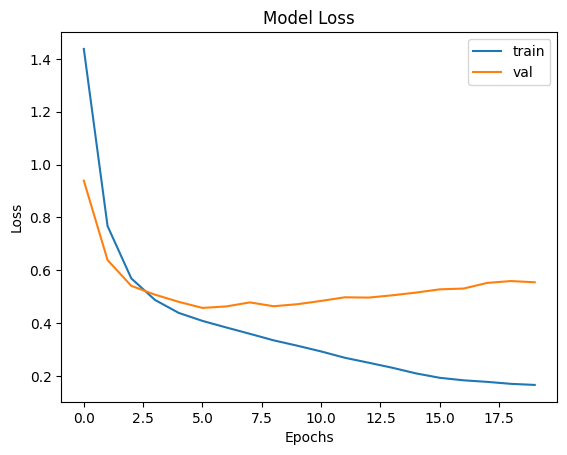

In [ ]:
# plot the loss
plt.plot(H.history['loss'], label='train')
plt.plot(H.history['val_loss'], label='val')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



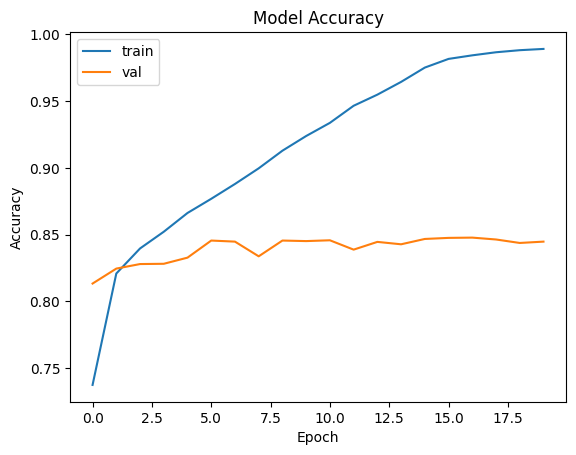

In [ ]:
# Plot accuracy
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

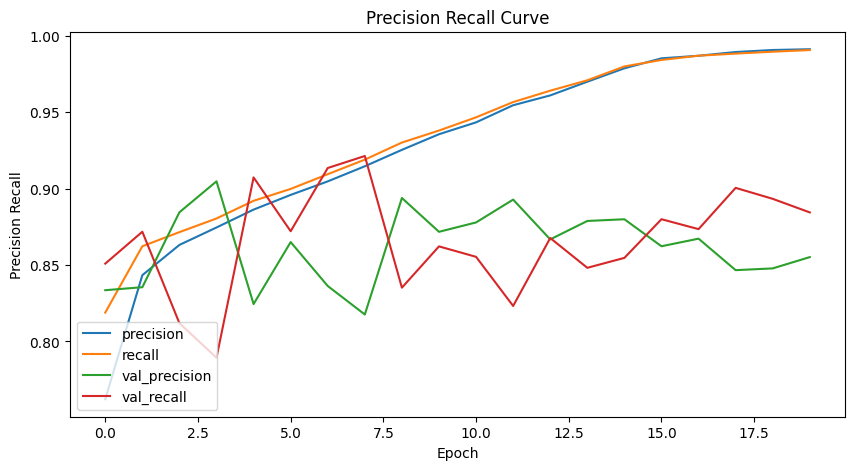

In [ ]:
# Plot precision recall curve
plt.figure(figsize=(10, 5))
plt.plot(H.history['precision'], label='precision')
plt.plot(H.history['recall'], label='recall')
plt.plot(H.history['val_precision'], label='val_precision')
plt.plot(H.history['val_recall'], label='val_recall')
plt.title('Precision Recall Curve')
plt.xlabel('Epoch')
plt.ylabel('Precision Recall')
plt.legend(loc='lower left')
plt.show()